# v9 Cross-Lingual Neural Sparse Model - Inference Test

v9 모델의 성능을 평가하고 v8과 비교합니다.

## v9 개선 사항
- **Self weight 감소**: 1.0 → 0.3 (한글 토큰 독점 방지)
- **Target weight 증가**: 1.0 → 2.0 (영어 활성화 강화)
- **Margin 강화**: 0.5 → 1.5 (최소 활성화 보장)
- **Negative Sampling**: 비타겟 언어 억제

## 1. Setup

In [1]:
import sys
import json
from pathlib import Path

def find_project_root():
    candidates = [
        Path.cwd(),
        Path.cwd().parent,
        Path.cwd().parent.parent,
        Path("/home/west/Documents/cursor-workspace/opensearch-neural-pre-train"),
    ]
    for candidate in candidates:
        if (candidate / "CLAUDE.md").exists() or (candidate / ".git").exists():
            return candidate
    return Path("/home/west/Documents/cursor-workspace/opensearch-neural-pre-train")

project_root = find_project_root()
sys.path.insert(0, str(project_root))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from src.model.splade_model import create_splade_model

plt.rcParams['font.family'] = 'DejaVu Sans'

print(f"Project root: {project_root}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train
PyTorch version: 2.10.0.dev20251109+cu130
CUDA available: True


## 2. Load v9 Model

In [2]:
MODEL_NAME = "bert-base-multilingual-cased"
V9_CHECKPOINT_PATH = project_root / "outputs/v9_cross_lingual/final_model.pt"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

Using device: cuda
Tokenizer vocab size: 119547


In [3]:
# Load v9 model
model_v9 = create_splade_model(
    model_name=MODEL_NAME,
    use_idf=False,
    use_expansion=True,
    expansion_mode="mlm",
)

checkpoint_v9 = torch.load(V9_CHECKPOINT_PATH, map_location=device, weights_only=True)
model_v9.load_state_dict(checkpoint_v9['model_state_dict'])
model_v9 = model_v9.to(device)
model_v9.eval()

print("v9 Model loaded successfully!")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)

v9 Model loaded successfully!


In [4]:
# Try to load v8 model for comparison
V8_CHECKPOINT_PATH = project_root / "outputs/v8_cross_lingual/final_model.pt"

model_v8 = None
if V8_CHECKPOINT_PATH.exists():
    model_v8 = create_splade_model(
        model_name=MODEL_NAME,
        use_idf=False,
        use_expansion=True,
        expansion_mode="mlm",
    )
    checkpoint_v8 = torch.load(V8_CHECKPOINT_PATH, map_location=device, weights_only=True)
    model_v8.load_state_dict(checkpoint_v8['model_state_dict'])
    model_v8 = model_v8.to(device)
    model_v8.eval()
    print("v8 Model loaded for comparison!")
else:
    print("v8 checkpoint not found, skipping comparison")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


v8 Model loaded for comparison!


## 3. Helper Functions

In [5]:
def encode_text(text: str, max_length: int = 64):
    return tokenizer(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

def get_sparse_representation(model, text: str, top_k: int = 50):
    encoding = encode_text(text)
    with torch.no_grad():
        sparse_rep, _ = model(
            encoding['input_ids'].to(device),
            encoding['attention_mask'].to(device)
        )
    sparse_rep = sparse_rep[0].cpu()
    top_scores, top_indices = torch.topk(sparse_rep, k=top_k)
    top_tokens = tokenizer.convert_ids_to_tokens(top_indices.tolist())
    return top_tokens, top_scores.tolist(), sparse_rep

def get_input_token_ids(text: str):
    encoding = tokenizer(text, add_special_tokens=False)
    return encoding['input_ids']

def is_korean_token(token: str) -> bool:
    clean = token.replace('##', '')
    return any('\uac00' <= c <= '\ud7a3' for c in clean)

def is_english_token(token: str) -> bool:
    clean = token.replace('##', '')
    return clean.isalpha() and clean.isascii()

def is_non_target_token(token: str) -> bool:
    """Check if token is from non-target language."""
    clean = token.replace('##', '')
    if not clean:
        return False
    has_korean = any('\uac00' <= c <= '\ud7a3' for c in clean)
    has_english = any(c.isalpha() and c.isascii() for c in clean)
    if has_korean or has_english:
        return False
    # Check for Japanese, Chinese, Cyrillic, etc.
    has_japanese = any('\u3040' <= c <= '\u309f' or '\u30a0' <= c <= '\u30ff' for c in clean)
    has_cjk = any('\u4e00' <= c <= '\u9fff' for c in clean)
    has_cyrillic = any('\u0400' <= c <= '\u04ff' for c in clean)
    return has_japanese or has_cjk or has_cyrillic

## 4. Cross-Lingual Evaluation

In [6]:
TEST_PAIRS = [
    ("머신러닝", ["machine", "learning"]),
    ("딥러닝", ["deep", "learning"]),
    ("자연어처리", ["natural", "language", "processing"]),
    ("인공지능", ["artificial", "intelligence"]),
    ("신경망", ["neural", "network"]),
    ("알고리즘", ["algorithm"]),
    ("데이터베이스", ["database"]),
    ("프로그래밍", ["programming"]),
    ("소프트웨어", ["software"]),
    ("하드웨어", ["hardware"]),
    ("학습", ["training", "learning"]),
    ("모델", ["model"]),
    ("데이터", ["data"]),
    ("컴퓨터", ["computer"]),
    ("네트워크", ["network"]),
]

In [7]:
def evaluate_model_full(model, test_pairs, top_k=50):
    """Full evaluation with Korean preservation, English activation, and non-target count."""
    results = []
    total_ko_preserved = 0
    total_ko_tokens = 0
    total_en_activated = 0
    total_en_expected = 0
    total_non_target = 0
    
    for ko_term, en_synonyms in test_pairs:
        tokens, scores, _ = get_sparse_representation(model, ko_term, top_k)
        tokens_lower = [t.lower() for t in tokens]
        
        # Korean preservation
        input_ids = get_input_token_ids(ko_term)
        input_tokens = set(tokenizer.convert_ids_to_tokens(input_ids))
        preserved = [t for t in input_tokens if t in tokens]
        total_ko_preserved += len(preserved)
        total_ko_tokens += len(input_tokens)
        
        # English activation
        activated_en = []
        for en_syn in en_synonyms:
            en_toks = tokenizer.tokenize(en_syn.lower())
            for en_tok in en_toks:
                total_en_expected += 1
                if en_tok.lower() in tokens_lower:
                    total_en_activated += 1
                    activated_en.append(en_tok)
        
        # Non-target count
        non_target_count = sum(1 for t in tokens if is_non_target_token(t))
        total_non_target += non_target_count
        
        results.append({
            'Korean': ko_term,
            'KO Preserved': ', '.join(preserved) if preserved else '-',
            'EN Expected': ', '.join(en_synonyms),
            'EN Activated': ', '.join(activated_en) if activated_en else '-',
            'Top-5': ', '.join(tokens[:5]),
            'Non-target': non_target_count,
            'KO OK': len(preserved) > 0,
            'EN OK': len(activated_en) > 0,
        })
    
    ko_rate = total_ko_preserved / total_ko_tokens * 100 if total_ko_tokens > 0 else 0
    en_rate = total_en_activated / total_en_expected * 100 if total_en_expected > 0 else 0
    avg_non_target = total_non_target / len(test_pairs)
    
    return {
        'ko_rate': ko_rate,
        'en_rate': en_rate,
        'avg_non_target': avg_non_target,
        'details': pd.DataFrame(results),
    }

In [8]:
# Evaluate v9
print("=" * 80)
print("v9 Evaluation Results")
print("=" * 80)

v9_eval = evaluate_model_full(model_v9, TEST_PAIRS)

print(f"\nKorean Preservation Rate: {v9_eval['ko_rate']:.1f}%")
print(f"English Activation Rate: {v9_eval['en_rate']:.1f}%")
print(f"Avg Non-target in Top-50: {v9_eval['avg_non_target']:.1f}")

v9_eval['details']

v9 Evaluation Results

Korean Preservation Rate: 100.0%
English Activation Rate: 21.7%
Avg Non-target in Top-50: 9.3


,Korean,KO Preserved,EN Expected,EN Activated,Top-5,Non-target,KO OK,EN OK
0,머신러닝,"머신, ##닝, ##러","machine, learning",machine,"##러, ##닝, 머신, ##로, ##런",3,True,True
1,딥러닝,"##닝, 딥, ##러","deep, learning",-,"##닝, ##러, 딥, ##로, ##루",1,True,False
2,자연어처리,"##어, 자, ##처, ##리, ##연","natural, language, processing",-,"##리, ##처, ##연, 자, ##어",2,True,False
3,인공지능,"인, ##지, ##능, ##공","artificial, intelligence",-,"##공, ##지, ##능, 인, 지",0,True,False
4,신경망,"##경, ##망, 신","neural, network",-,"##경, 신, 경, ##망, ##의",0,True,False
5,알고리즘,"##고, ##리, 알, ##즘",algorithm,-,"##즘, ##고, 알, ##리, ##로",0,True,False
6,데이터베이스,"##이터, ##베, ##이스, 데",database,-,"##이터, ##이스, 데, ##베, ##B",7,True,False
7,프로그래밍,"##밍, ##그, 프로, ##래",programming,-,"##래, ##그, ##밍, 프로, ##グ",16,True,False
8,소프트웨어,"##어, ##프트, ##웨, 소",software,-,"##프트, ##웨, 소, ##어, ##어는",26,True,False
9,하드웨어,"##어, ##웨, ##드, 하",hardware,-,"##웨, ##어, 하, ##드, ##어는",5,True,False


In [9]:
# Evaluate v8 if available
if model_v8 is not None:
    print("\n" + "=" * 80)
    print("v8 Evaluation Results (for comparison)")
    print("=" * 80)
    
    v8_eval = evaluate_model_full(model_v8, TEST_PAIRS)
    
    print(f"\nKorean Preservation Rate: {v8_eval['ko_rate']:.1f}%")
    print(f"English Activation Rate: {v8_eval['en_rate']:.1f}%")
    print(f"Avg Non-target in Top-50: {v8_eval['avg_non_target']:.1f}")


v8 Evaluation Results (for comparison)

Korean Preservation Rate: 100.0%
English Activation Rate: 17.4%
Avg Non-target in Top-50: 19.9


## 5. v8 vs v9 Comparison


v8 vs v9 COMPARISON
               Metric     v8     v9 Change
  Korean Preservation 100.0% 100.0%  +0.0%
   English Activation  17.4%  21.7%  +4.3%
Avg Non-target Tokens   19.9    9.3  -10.6


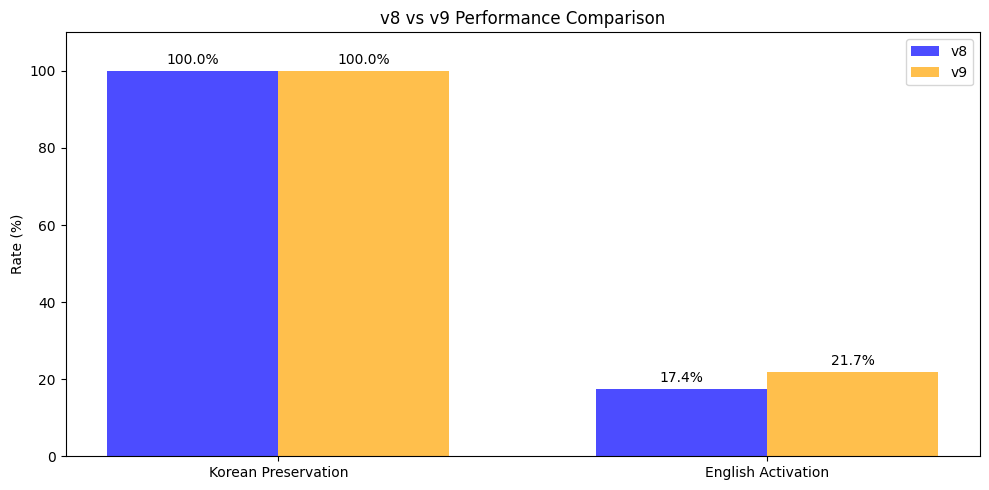

In [10]:
if model_v8 is not None:
    print("\n" + "=" * 80)
    print("v8 vs v9 COMPARISON")
    print("=" * 80)
    
    comparison_data = {
        'Metric': ['Korean Preservation', 'English Activation', 'Avg Non-target Tokens'],
        'v8': [f"{v8_eval['ko_rate']:.1f}%", f"{v8_eval['en_rate']:.1f}%", f"{v8_eval['avg_non_target']:.1f}"],
        'v9': [f"{v9_eval['ko_rate']:.1f}%", f"{v9_eval['en_rate']:.1f}%", f"{v9_eval['avg_non_target']:.1f}"],
        'Change': [
            f"{v9_eval['ko_rate'] - v8_eval['ko_rate']:+.1f}%",
            f"{v9_eval['en_rate'] - v8_eval['en_rate']:+.1f}%",
            f"{v9_eval['avg_non_target'] - v8_eval['avg_non_target']:+.1f}"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Bar chart comparison
    fig, ax = plt.subplots(figsize=(10, 5))
    
    x = np.arange(2)
    width = 0.35
    
    bars1 = ax.bar(x - width/2, [v8_eval['ko_rate'], v8_eval['en_rate']], width, label='v8', color='blue', alpha=0.7)
    bars2 = ax.bar(x + width/2, [v9_eval['ko_rate'], v9_eval['en_rate']], width, label='v9', color='orange', alpha=0.7)
    
    ax.set_ylabel('Rate (%)')
    ax.set_title('v8 vs v9 Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(['Korean Preservation', 'English Activation'])
    ax.legend()
    ax.set_ylim(0, 110)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

## 6. Detailed Token Analysis

In [11]:
def display_comparison(term: str, top_k: int = 20):
    """Display v8 vs v9 token comparison for a term."""
    print(f"\n{'='*70}")
    print(f"Term: '{term}'")
    print(f"{'='*70}")
    
    input_ids = get_input_token_ids(term)
    input_tokens = set(tokenizer.convert_ids_to_tokens(input_ids))
    print(f"Input tokens: {list(input_tokens)}")
    
    v9_tokens, v9_scores, _ = get_sparse_representation(model_v9, term, top_k)
    
    v9_preserved = [t for t in input_tokens if t in v9_tokens]
    v9_english = [t for t in v9_tokens if is_english_token(t) and t not in ['the', 'a', 'an', 'in', 'of']]
    v9_non_target = sum(1 for t in v9_tokens if is_non_target_token(t))
    
    print(f"\nv9 Results:")
    print(f"  Top-10: {', '.join(v9_tokens[:10])}")
    print(f"  KO preserved: {v9_preserved}")
    print(f"  EN tokens: {v9_english[:5]}")
    print(f"  Non-target count: {v9_non_target}")
    
    if model_v8 is not None:
        v8_tokens, v8_scores, _ = get_sparse_representation(model_v8, term, top_k)
        v8_preserved = [t for t in input_tokens if t in v8_tokens]
        v8_english = [t for t in v8_tokens if is_english_token(t) and t not in ['the', 'a', 'an', 'in', 'of']]
        v8_non_target = sum(1 for t in v8_tokens if is_non_target_token(t))
        
        print(f"\nv8 Results:")
        print(f"  Top-10: {', '.join(v8_tokens[:10])}")
        print(f"  KO preserved: {v8_preserved}")
        print(f"  EN tokens: {v8_english[:5]}")
        print(f"  Non-target count: {v8_non_target}")

In [12]:
# Detailed comparison for key terms
key_terms = ["머신러닝", "딥러닝", "자연어처리", "인공지능", "데이터"]

for term in key_terms:
    display_comparison(term)


Term: '머신러닝'
Input tokens: ['머신', '##닝', '##러']

v9 Results:
  Top-10: ##러, ##닝, 머신, ##로, ##런, ။, 러, 이, ##링, machine
  KO preserved: ['머신', '##닝', '##러']
  EN tokens: ['machine', 'wa']
  Non-target count: 1

v8 Results:
  Top-10: ##러, 머신, ##닝, ##런, ။, ##ور, wa, 驅, ##로, machine
  KO preserved: ['머신', '##닝', '##러']
  EN tokens: ['wa', 'machine', '##over']
  Non-target count: 7

Term: '딥러닝'
Input tokens: ['##닝', '딥', '##러']

v9 Results:
  Top-10: ##닝, ##러, 딥, ##로, ##루, ##레, ##래, 러, ##플, 이
  KO preserved: ['##닝', '딥', '##러']
  EN tokens: []
  Non-target count: 0

v8 Results:
  Top-10: ##러, 딥, ##닝, ##로, ##over, ##ورد, ##ол, ##्ल, ##플, 片
  KO preserved: ['##닝', '딥', '##러']
  EN tokens: ['##over']
  Non-target count: 4

Term: '자연어처리'
Input tokens: ['##어', '자', '##처', '##리', '##연']

v9 Results:
  Top-10: ##리, ##처, ##연, 자, ##어, ##리를, ##리는, ##리로, ##어로, 처
  KO preserved: ['##어', '자', '##처', '##리', '##연']
  EN tokens: []
  Non-target count: 0

v8 Results:
  Top-10: ##처, ##리, ##어, ##연, 자, ##리를, ##

## 7. Custom Query Test

In [13]:
custom_queries = [
    "파이썬 프로그래밍",
    "웹 개발",
    "클라우드 컴퓨팅",
    "빅데이터 분석",
    "사이버 보안",
    "검색 엔진",
    "추천 시스템",
]

print("v9 Custom Query Results")
print("=" * 80)

for query in custom_queries:
    tokens, scores, _ = get_sparse_representation(model_v9, query, top_k=20)
    input_ids = get_input_token_ids(query)
    input_tokens = set(tokenizer.convert_ids_to_tokens(input_ids))
    
    preserved = [t for t in input_tokens if t in tokens]
    en_tokens = [t for t in tokens if is_english_token(t) and t not in ['the', 'a', 'an', 'in', 'of', 'to', 'and']]
    non_target = sum(1 for t in tokens if is_non_target_token(t))
    
    print(f"\n{query}:")
    print(f"  KO preserved: {preserved if preserved else 'None'}")
    print(f"  EN tokens: {', '.join(en_tokens[:5]) if en_tokens else 'None'}")
    print(f"  Non-target: {non_target}")
    print(f"  Top-5: {', '.join(tokens[:5])}")

v9 Custom Query Results

파이썬 프로그래밍:
  KO preserved: ['프로', '##밍', '##썬', '##래', '##그', '##이', '파']
  EN tokens: ##y, ##og, ##g, ##ch
  Non-target: 2
  Top-5: ##래, ##썬, ##밍, ##이, ##그

웹 개발:
  KO preserved: ['웹', '개발']
  EN tokens: cloud, application, development, learning, applications
  Non-target: 2
  Top-5: 웹, 개발, cloud, 이, application

클라우드 컴퓨팅:
  KO preserved: ['클', '##라', '##퓨', '##드', '컴', '##팅', '##우']
  EN tokens: ##d, ##ro, ##ra
  Non-target: 2
  Top-5: ##퓨, ##우, 컴, ##라, ##팅

빅데이터 분석:
  KO preserved: ['##이터', '##데', '분', '##석', '빅']
  EN tokens: None
  Non-target: 3
  Top-5: ##이터, ##데, 분, 데, 빅

사이버 보안:
  KO preserved: ['사', '##이', '보', '##안', '##버']
  EN tokens: ##y
  Non-target: 0
  Top-5: ##이, ##안, 보, ##버, 사

검색 엔진:
  KO preserved: ['엔', '##색', '검', '##진']
  EN tokens: None
  Non-target: 0
  Top-5: 검, ##진, ##색, 엔, ##검

추천 시스템:
  KO preserved: ['시', '##천', '##템', '##스', '추']
  EN tokens: None
  Non-target: 1
  Top-5: ##템, 시, 추, ##스, ##천


## 8. Summary

In [14]:
print("\n" + "=" * 70)
print("v9 INFERENCE TEST COMPLETE")
print("=" * 70)

print(f"\nv9 Final Results:")
print(f"  Korean Preservation: {v9_eval['ko_rate']:.1f}%")
print(f"  English Activation: {v9_eval['en_rate']:.1f}%")
print(f"  Avg Non-target: {v9_eval['avg_non_target']:.1f}")

if model_v8 is not None:
    print(f"\nImprovement over v8:")
    print(f"  Korean Preservation: {v9_eval['ko_rate'] - v8_eval['ko_rate']:+.1f}%")
    print(f"  English Activation: {v9_eval['en_rate'] - v8_eval['en_rate']:+.1f}%")
    print(f"  Non-target Reduction: {v8_eval['avg_non_target'] - v9_eval['avg_non_target']:+.1f}")


v9 INFERENCE TEST COMPLETE

v9 Final Results:
  Korean Preservation: 100.0%
  English Activation: 21.7%
  Avg Non-target: 9.3

Improvement over v8:
  Korean Preservation: +0.0%
  English Activation: +4.3%
  Non-target Reduction: +10.6
